# Notebook for CCI-derived metabolism from scRNA-Seq using MEBOCOST in Fetal Stem Cells
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 16th November 2023

### Import packages

In [58]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

### Set up the cells

In [59]:
%matplotlib inline

In [60]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         10.1.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.07.22
cffi         

In [61]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [62]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [63]:
input_path = '/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/Fetal_healthy_stem_cells_leiden.h5ad'
adata = sc.read_h5ad(input_path)

In [64]:
# Extract the raw counts
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 7817 × 19868
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Age_colors', 'Age_group_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [65]:
X_is_raw(adata)

True

In [66]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e6)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Infer metabolic communications

* The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.

In [67]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['cluster'],
                        met_est = 'mebocost',
                        config_path = '/home/amaguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[November 20, 2023 16:08:38]: We get expression data with 19868 genes and 7817 cells.
[November 20, 2023 16:08:38]: Data Preparation Done in 0.0596 seconds


### Estimate metabolite presence

* If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [68]:
mebo_obj._load_config_()
mebo_obj.estimator()

[November 20, 2023 16:08:40]: Load config and read data based on given species [human].
[November 20, 2023 16:08:42]: Estimtate metabolite level using mebocost


In [69]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,AAACCTGCATCTACGA-1-Human_colon_16S8159182,AAACGGGTCGGCGCAT-1-Human_colon_16S8159182,AAACGGGTCTTACCGC-1-Human_colon_16S8159182,AAAGATGAGATATACG-1-Human_colon_16S8159182,AAAGATGGTCTCCATC-1-Human_colon_16S8159182,AAAGATGTCACCTTAT-1-Human_colon_16S8159182,AAAGCAAGTGACCAAG-1-Human_colon_16S8159182,AAAGCAATCCCTAACC-1-Human_colon_16S8159182,AAAGCAATCGACGGAA-1-Human_colon_16S8159182,AAAGTAGCAAGCCATT-1-Human_colon_16S8159182,...,CCAATCCCACCACCAG-1-4918STDY7718977,CCAGCGACATCTGGTA-1-4918STDY7718977,CCGTACTCACGTAAGG-1-4918STDY7718977,CCTTCGATCCACGTGG-1-4918STDY7718977,CGTAGCGTCGCCAAAT-1-4918STDY7718977,CTAGCCTAGTGAACGC-1-4918STDY7718977,CTCGTACGTCAAACTC-1-4918STDY7718977,CTGTGCTAGGATGTAT-1-4918STDY7718977,GATCGTAAGTAGGTGC-1-4918STDY7718977,TCAGCAAAGTGCGATG-1-4918STDY7718977
HMDB0003450,0.000000,0.000000,2.198213,0.000000,2.200197,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
HMDB0003948,2.006391,0.774729,2.864287,1.876569,1.552118,0.718439,2.318436,2.072294,1.508554,2.270480,...,0.0,2.141106,1.363393,0.748425,0.890024,2.069938,0.0,2.556283,0.933507,0.818207
HMDB0003712,1.560526,0.602567,2.716270,2.301832,1.696135,0.558786,2.660349,2.098167,1.623309,1.765929,...,0.0,1.665305,1.628801,0.582108,0.692241,2.223174,0.0,1.988220,0.726061,0.636383
HMDB0003945,2.312151,0.677888,2.506251,2.115779,1.358103,0.628634,2.553150,1.813257,1.826223,1.986670,...,0.0,2.469254,1.832401,1.309743,0.778771,2.414927,0.0,2.236748,0.816818,1.518302
HMDB0003949,2.006391,0.774729,2.864287,1.876569,1.552118,0.718439,2.318436,2.072294,1.508554,2.270480,...,0.0,2.141106,1.363393,0.748425,0.890024,2.069938,0.0,2.556283,0.933507,0.818207


### MEBOCOST cell-cell communication inference

In [70]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[November 20, 2023 16:09:05]: Load config and read data based on given species [human].
[November 20, 2023 16:09:06]: Estimtate metabolite level using mebocost
[November 20, 2023 16:09:12]: Infer communications
[November 20, 2023 16:09:12]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[November 20, 2023 16:09:12]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[November 20, 2023 16:09:12]: met_sensor: (290, 8)
[November 20, 2023 16:09:12]: avg_exp: (2002, 3) for (gene, cell) of needed
[November 20, 2023 16:09:12]: avg_met: (578, 3) for (metabolite, cell) of needed
[November 20, 2023 16:09:12]: shuffling 1000 times for generating backgroud
[November 20, 2023 16:09:14]: take exp and met avg for shuffling
[November 20, 2023 16:09:18]: thread: 4
[November 20, 2023 16:09:19]: ABCA1 ~ HMDB0006247
[November 20, 2023 16:09:19]: Calculating P-value
[November 20, 2023 16:09:19]: Normalizing Cluster Mean and Calculating Communication Score
[November 20, 2023

In [71]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 4.14876651763916
metabolite_presence cutoff: 0.9213792085647583


In [72]:
# Save results
commu_res.to_csv('/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_mebocost/FetalSC_mebocost_results.csv')

### Visualise MEBOCOST prediction

### Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[November 20, 2023 16:09:36]: plot heatmap for significant result


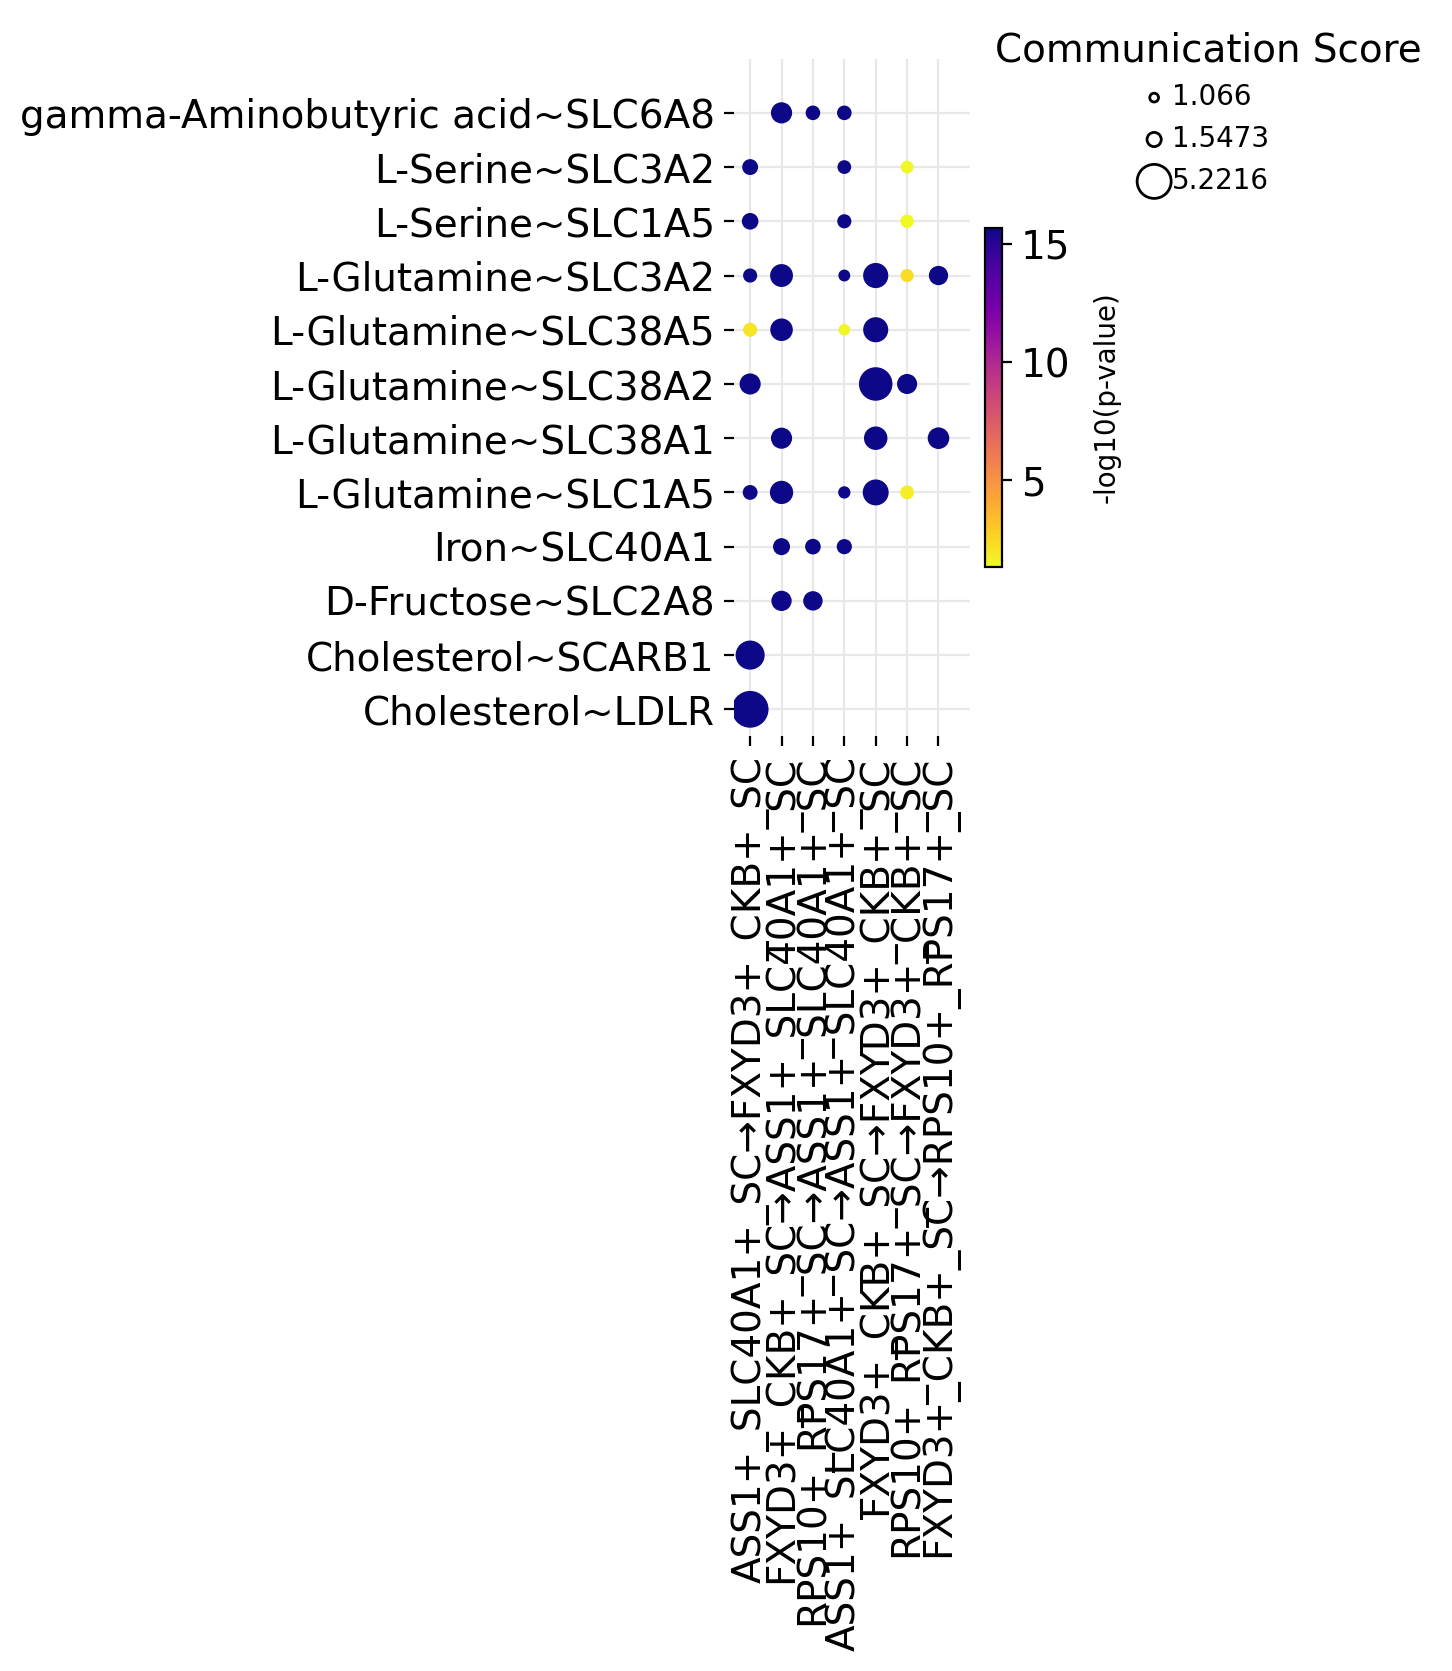

In [73]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 20, 2023 16:10:01]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


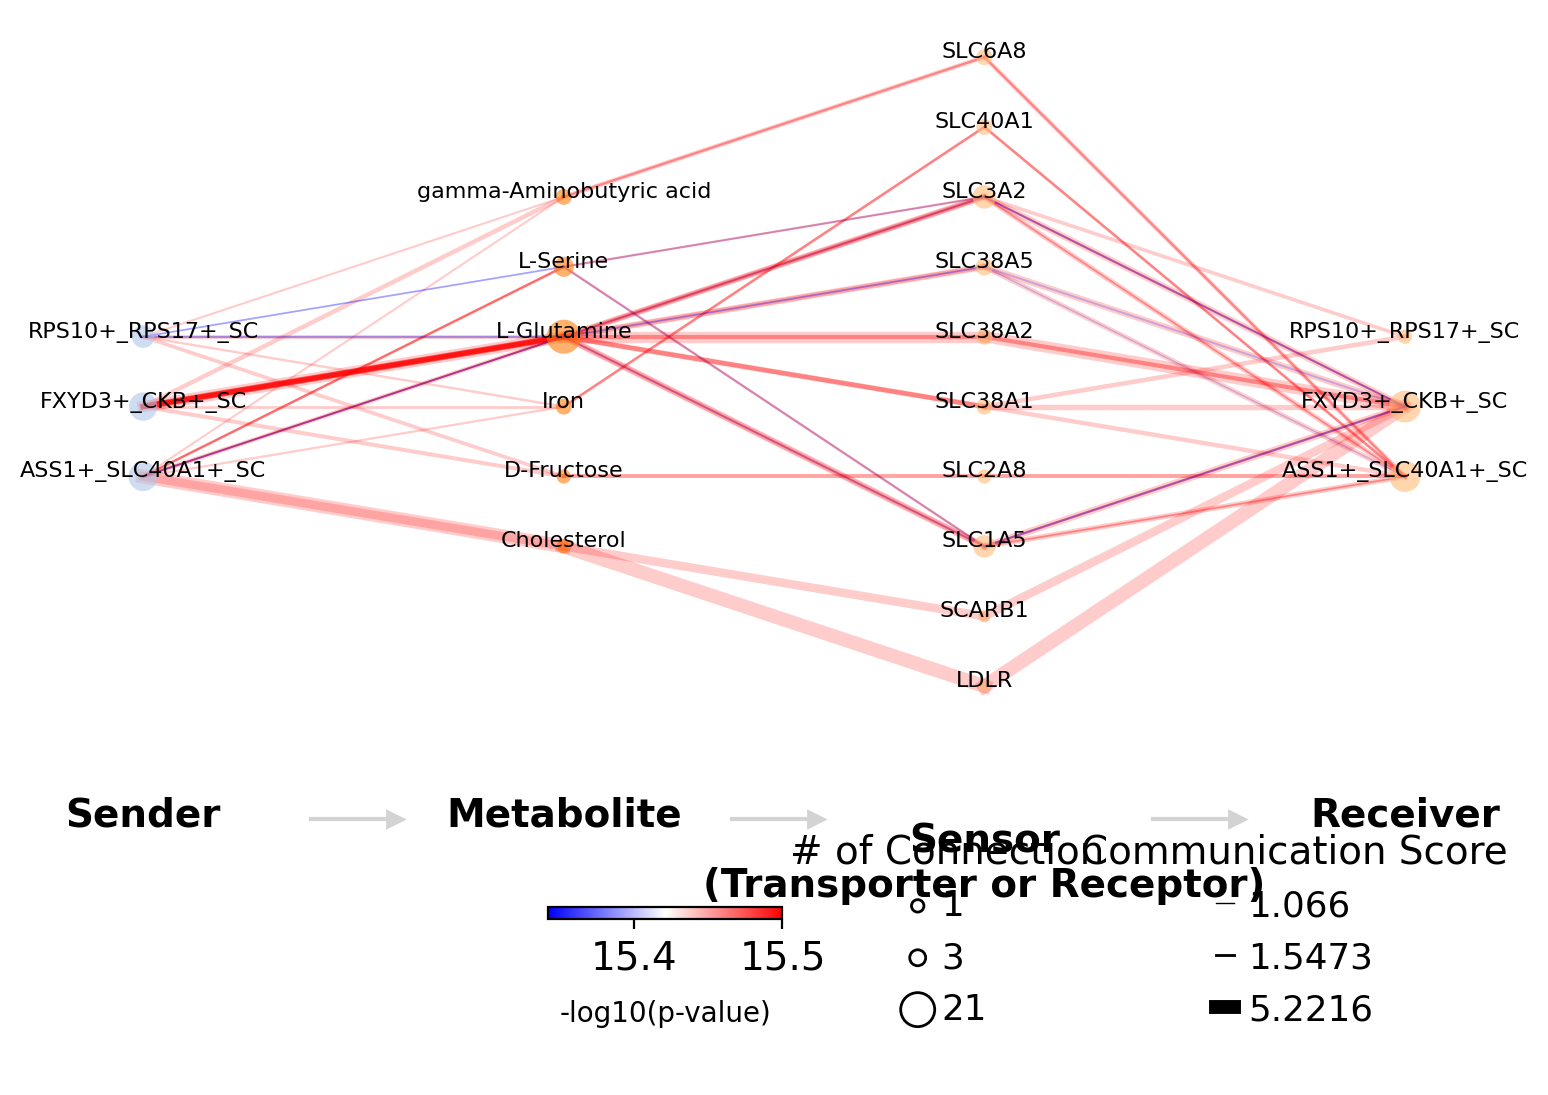

In [74]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 20, 2023 16:10:12]: Warnings: no sensors to plot
[November 20, 2023 16:10:12]: Find metabolites ['Iron', 'L-Glutamine', 'Cholesterol', 'L-Serine', 'gamma-Aminobutyric acid', 'D-Fructose'] to plot violin


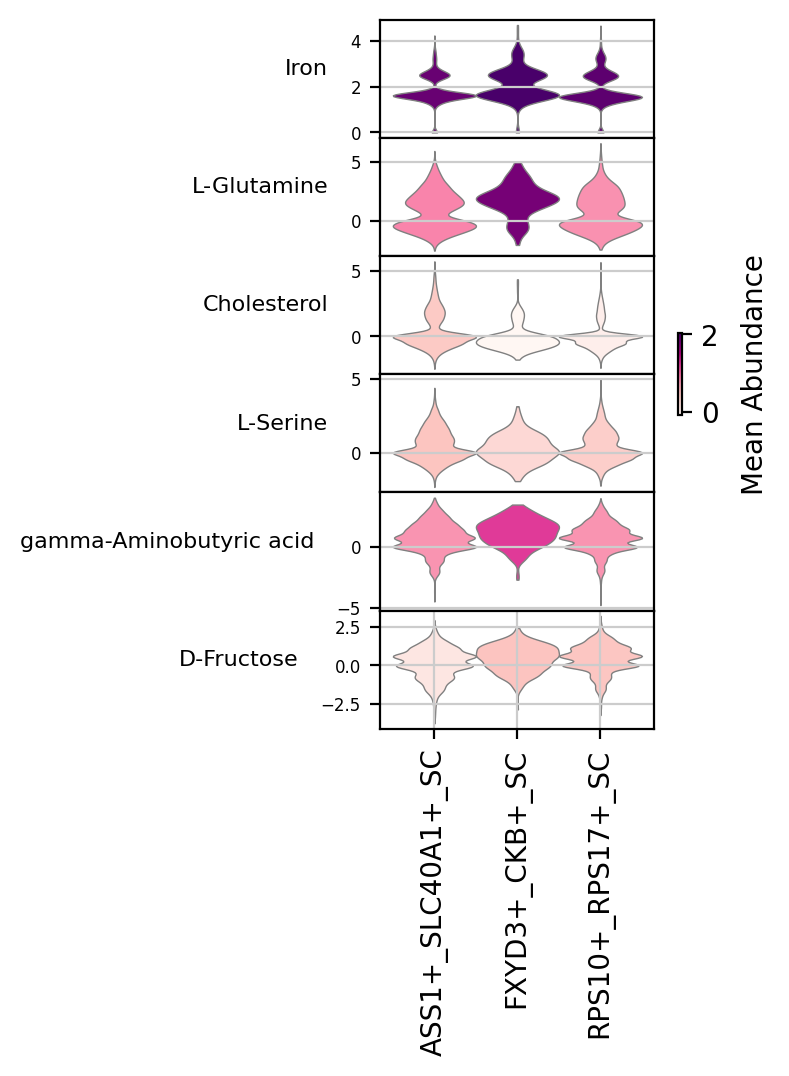

In [75]:
commu_df = mebo_obj.commu_res.copy()
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:15], ## only top 5 as example
                    cell_focus = [],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )